<a href="https://colab.research.google.com/github/Shubhranshu-Malhotra/Bulldozer-Price-Regression-Project/blob/master/Yoga_Supervisor_pilot_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os

## Step 1: Extract images from video 
**Warning:** This cell should only be run once to extract images and save to folder on drive.  
*  Extract images between `start_time` and `end_time`.  
*  Set a frame rate to limit the number of images being extracted each second.  

Reference: [Convert Video to Images (Frames) & Images (Frames) to Video using OpenCV (Python)](https://medium.com/@iKhushPatel/convert-video-to-images-images-to-video-using-opencv-python-db27a128a481)

In [ ]:
# Extract images

vid_path = "/content/drive/MyDrive/Datasets/yoga_supervisor/yoga_videos/"
images_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/yoga_2_2/'
# start_time = 32
current_time = 332
end_time = 384
cap_count = 1
frame_rate = 0.2 # take `1/frame_rate` images per second
vid_cap= cv2.VideoCapture(vid_path + 'yoga_2.mp4')
# vid_cap.set(cv2.CAP_PROP_POS_MSEC,start_time*1000)
# while (vid_cap.get(cv2.CAP_PROP_POS_MSEC)/1000 < end_time):
while(current_time<end_time):
  vid_cap.set(cv2.CAP_PROP_POS_MSEC,current_time*1000)
  ret, image = vid_cap.read()
  if ret == False:
      break
  if(cap_count%10 == 0):
    print(f"Saved {cap_count} images.")
    print(f"Current video time: {current_time:.2f}")
  # cv2_imshow(image)
  cv2.imwrite(images_path + "image_" + str(cap_count) + ".jpg", image)
  cap_count+=1
  current_time += frame_rate
print("stopped at : ", current_time - frame_rate )
print(f"saved {cap_count-1} images.")

## Step 2: Detect pose in image

### Learning Pose Estimation
Reference: [Realtime Multiple Person 2D Pose Estimation using TensorFlow2.x](https://towardsdatascience.com/realtime-multiple-person-2d-pose-estimation-using-tensorflow2-x-93e4c156d45f)

In [2]:
# !pip install tf_pose

In [84]:
import sys
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

In [85]:
model='mobilenet_thin'
resize='432x368'
w, h = model_wh(resize)

In [ ]:
global_e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

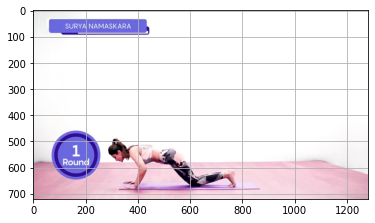

In [87]:
global_image_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/yoga_2_1/image_109.jpg'
global_image_plt = plt.imread(global_image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(global_image_plt)
plt.grid();

In [88]:
global_image_plt.shape

(720, 1280, 3)

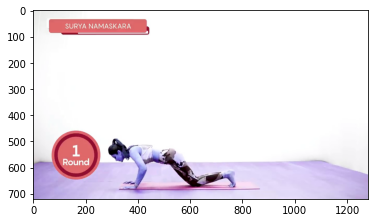

In [89]:
global_image_common = common.read_imgfile(global_image_path, None, None)
plt.imshow(global_image_common)

In [90]:
global_image_common.shape, type(global_image_common)

((720, 1280, 3), numpy.ndarray)

In [91]:
global_humans_common = global_e.inference(global_image_common, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)

In [92]:
global_humans_common

[BodyPart:0-(0.25, 0.78) score=0.69 BodyPart:1-(0.30, 0.74) score=0.56 BodyPart:2-(0.30, 0.74) score=0.37 BodyPart:3-(0.31, 0.79) score=0.12 BodyPart:5-(0.30, 0.76) score=0.72 BodyPart:6-(0.33, 0.84) score=0.79 BodyPart:7-(0.30, 0.91) score=0.76 BodyPart:8-(0.38, 0.79) score=0.37 BodyPart:11-(0.38, 0.78) score=0.35 BodyPart:12-(0.42, 0.76) score=0.27 BodyPart:13-(0.48, 0.89) score=0.45 BodyPart:15-(0.25, 0.77) score=0.81 BodyPart:17-(0.26, 0.75) score=0.83]

In [93]:
global_e.heatMat.shape

(184, 216, 19)

In [94]:
# probability values for each joint being in the topleftmost pixel. {1-17 for body parts}{18: None}
global_e.heatMat[0][0]

array([-1.1617886e-02,  2.5234930e-03,  1.2209974e-03,  4.4894167e-03,
       -5.9046829e-04,  1.1201315e-02,  6.1344728e-04, -1.1397861e-02,
        4.3532643e-03, -5.8582658e-03, -2.7521998e-03,  1.2501101e-03,
        2.6039509e-03,  1.8462986e-03, -2.1608062e-03, -1.1375099e-02,
        6.9902316e-03, -1.0783993e-02,  9.9766523e-01], dtype=float32)

In [95]:
# Since there is no body part in the topleft pixel NONE [index = 18] should have highest probability
global_e.heatMat[0][0][-1]

0.9976652

In [96]:
0.49*w, 0.33*h

(211.68, 121.44000000000001)

In [97]:
# Trial loop to find out the position of neck in the image
# rages are height/2 and width/2 as that is the shape of heatMat
body_part_index = 14
for wi in range(int(432/2)):
  for hi in range(int(368/2)):
    if(np.argmax(global_e.heatMat[hi][wi]) == body_part_index):
      print(f"height:{hi}, width:{wi}")
      print(global_e.heatMat[hi][wi])
      break

In [98]:
np.argmax(global_e.heatMat[125, 160])

18

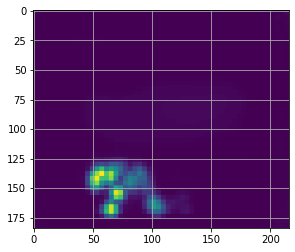

In [99]:
global_max_prob = np.amax(global_e.heatMat[:, :, :-1], axis=2)
plt.imshow(global_max_prob)
plt.grid();

In [100]:
print(np.max(global_max_prob[2]))

0.016600229


In [101]:
global_max_prob[56, 106]

0.0032752678

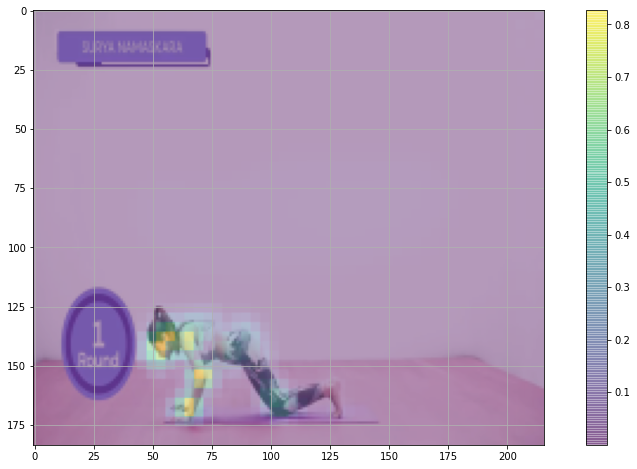

In [102]:
plt.figure(figsize=(15,8))
rgbimg = cv2.cvtColor(global_image_common.astype(np.uint8), cv2.COLOR_BGR2RGB)
rgbimg = cv2.resize(rgbimg, (global_e.heatMat.shape[1], global_e.heatMat.shape[0]), interpolation=cv2.INTER_AREA)
plt.imshow(rgbimg, alpha=0.7)
plt.imshow(global_max_prob, alpha=0.4)
plt.colorbar()
plt.grid();

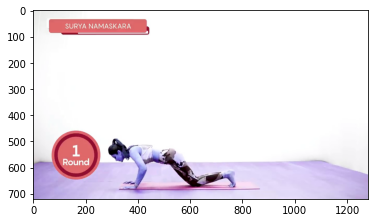

In [103]:
plt.imshow(global_image_common)

In [104]:
# Draws on the passed image(inplace) if `imgcopy = False`
drawn_image_common = TfPoseEstimator.draw_humans(global_image_common, global_humans_common, imgcopy=True)

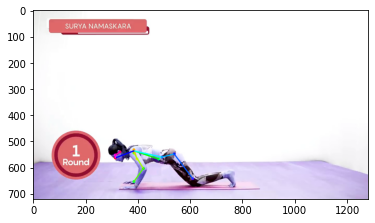

In [105]:
plt.imshow(drawn_image_common);
# plt.axis('off');

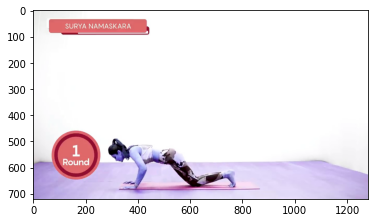

In [106]:
plt.imshow(global_image_common)

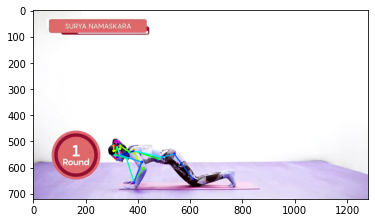

In [69]:
drawn_image_plt = TfPoseEstimator.draw_humans(global_image_plt, global_humans_plt, imgcopy=False)
plt.imshow(drawn_image_plt)

In [133]:
# To display just the skeleton (assembling all the necessary steps)
def display_skeleton(image_path, estimator, show_bg = False):
  """
  Takes image_path, estimator and show_bg as input and displays pose skeleton.
  """
  img = common.read_imgfile(image_path, None, None)
  humans = estimator.inference(img, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
  if(show_bg == True):
    skeleton = TfPoseEstimator.draw_humans(img, humans, imgcopy=True)
  else:
    black_background = np.zeros(img.shape)
    skeleton = TfPoseEstimator.draw_humans(black_background, humans, imgcopy=True)
  plt.figure(figsize=(15,8))
  plt.imshow(skeleton);
  plt.grid(); 
  plt.axis('off');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


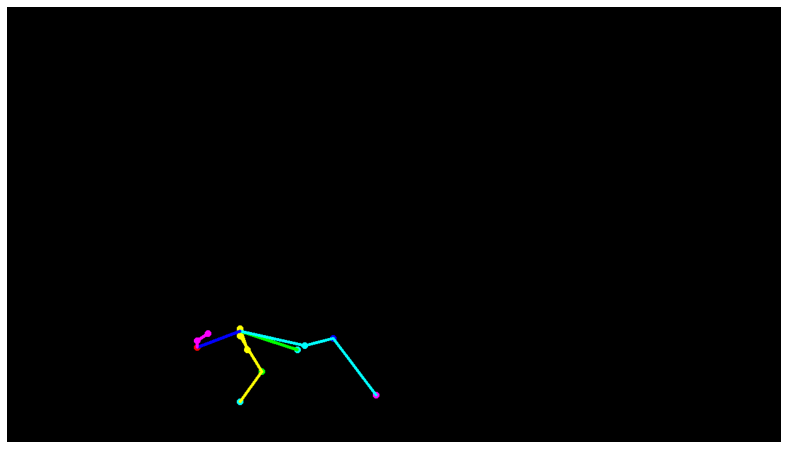

In [136]:
display_skeleton(global_image_path, global_e)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


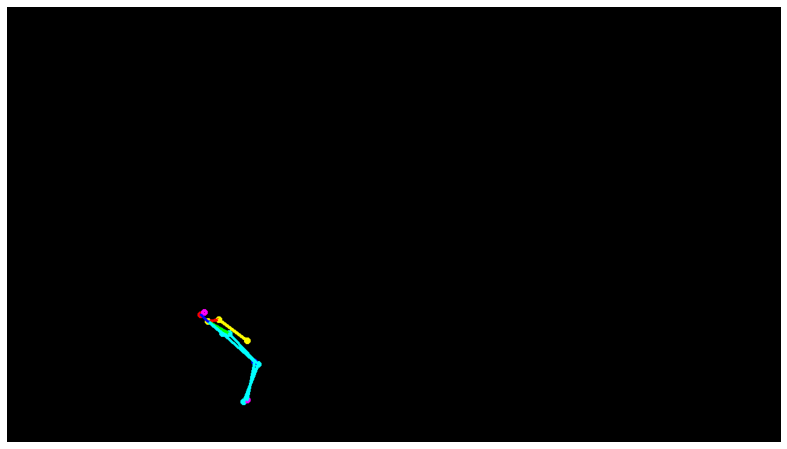

In [129]:
# To display just the skeleton using image read using `plt.imread`
global_image_plt = plt.imread(global_image_path)
# skeleton_test = cv2.cvtColor(global_image_plt.astype(np.uint8), cv2.COLOR_RGB2XYZ)
global_humans_plt = global_e.inference(global_image_plt, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
black_background = np.zeros(skeleton_test.shape)
skeleton = TfPoseEstimator.draw_humans(black_background, global_humans_plt, imgcopy=True)
plt.figure(figsize=(15,8))
plt.imshow(skeleton);
plt.grid(); 
plt.axis('off');

From the above we infer that reading file as `BGR` gives better pose estimation than as `RGB`. Results given by `XYZ` image also worth exploring.

**Getting absolute join coordinates using the relative ones obtained using `e.inference()`**

In [142]:
# Extracting just the points
global_keypoints = str(str(str(global_humans_common[0]).split('BodyPart:')[1:]).split('-')).split(' score=')

In [140]:
str(str(str(global_humans_common[0]).split('BodyPart:')[1:]).split('-')).split(' score=')[0][10:-1]

'0.25, 0.78'

In [143]:
global_keypoints_list=[]
for i in range (len(global_keypoints)-1): 
    pnt = global_keypoints[i][-11:-1]
    pnt = tuple(map(float, pnt.split(', ')))
    global_keypoints_list.append(pnt)
print(global_keypoints_list)

[(0.25, 0.78), (0.3, 0.74), (0.3, 0.74), (0.31, 0.79), (0.3, 0.76), (0.33, 0.84), (0.3, 0.91), (0.38, 0.79), (0.38, 0.78), (0.42, 0.76), (0.48, 0.89), (0.25, 0.77), (0.26, 0.75)]


In [166]:
global_keypts_array = np.array(global_keypoints_list)
global_keypts_array = global_keypts_array*(image.shape[1],image.shape[0])
global_keypts_array = global_keypts_array.astype(int)
global_keypts_array

array([[320, 561],
       [384, 532],
       [384, 532],
       [396, 568],
       [384, 547],
       [422, 604],
       [384, 655],
       [486, 568],
       [486, 561],
       [537, 547],
       [614, 640],
       [320, 554],
       [332, 540]])

### Cleaning and Functionalizing Important things for Pose Estimation

In [ ]:
# !pip install tf_pose

In [ ]:
import sys
import time
import logging
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

In [ ]:
global_image_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/yoga_2_1/image_109.jpg'
model='mobilenet_thin'
resize='432x368'
global_image = common.read_imgfile(global_image_path, None, None)
w, h = model_wh(resize)
global_e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
# plt.imshow(global_image)
global_humans = global_e.inference(global_image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)


In [156]:
# Now let us functionalize getting human pose
def get_pose(image_path, estimator, show_BG = True):
  """
  returns image with pose shown, relative human joints position
  """ 
  image = common.read_imgfile(image_path, None, None)
  humans = estimator.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
  if show_BG == False:
        image = np.zeros(image.shape)
  image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
  image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
  return image, humans

In [157]:
# Now let us functionalize getting human pose
def show_pose(image_path, estimator, show_BG = True):
  """
  Shows the skeletal pose for the passed image.
  """
  image = common.read_imgfile(image_path, None, None)
  humans = estimator.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
  if show_BG == False:
        image = np.zeros(image.shape)
  image = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
  image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
  plt.figure(figsize=(15,8))
  plt.imshow(image);
  plt.grid(); 
  plt.axis('off');
  return image, humans

In [158]:
def show_heatmap(image, estimator, show_BG = True):
  """
  shows image heatmap showing keypoints
  """
  max_prob = np.amax(estimator.heatMat[:, :, :-1], axis=2)
  plt.figure(figsize=(15,8))
  bgimg = cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB)
  bgimg = cv2.resize(bgimg, (estimator.heatMat.shape[1], estimator.heatMat.shape[0]), interpolation=cv2.INTER_AREA)
  if (show_BG == True):
    plt.imshow(bgimg, alpha=0.7)
    plt.imshow(max_prob, alpha=0.4)
  else:
    plt.imshow(max_prob)
  plt.colorbar()
  plt.grid();

In [167]:
def show_keypoints(image, humans, color='orange', show_BG = 'original'):
    """
    takes in image and relative keypoint values and 
    displays image with kepoints on it.
    """
    keypoints = str(str(str(humans[0]).split('BodyPart:')[1:]).split('-')).split(' score=')
    keypoints_list=[]
    for i in range (len(keypoints)-1): 
        pnt = keypoints[i][-11:-1]
        pnt = tuple(map(float, pnt.split(', ')))
        keypoints_list.append(pnt)

    keypts_array = np.array(keypoints_list)
    keypts_array = keypts_array*(image.shape[1],image.shape[0])
    keypts_array = keypts_array.astype(int)
    keypts_array

    plt.figure(figsize=(10,10))
    plt.axis([0, image.shape[1], 0, image.shape[0]])  
    
       
    if show_BG == 'black':
      image = np.zeros(image.shape)
      plt.imshow(image)
    elif show_BG == 'original': 
      plt.imshow(image)
    elif show_BG == 'white':
      pass
    else:
      return "Please enter a valid value for 'show_BG'. 'show_BG' can take following values: 'original','black','white'."
    plt.scatter(*zip(*keypts_array), s=200, color=color, alpha=0.6)
    ax=plt.gca() 
    ax.set_ylim(ax.get_ylim()[::-1]) 
    ax.xaxis.tick_top() 
    plt.title('{} keypoints detected\n'.format(len(keypts_array)))
    plt.grid();

    for i, txt in enumerate(keypts_array):
        ax.annotate(i, (keypts_array[i][0]-5, keypts_array[i][1]+5))
            
    return keypts_array

In [168]:
def get_keypoints(image, humans):
  """
    takes in a single image and the relative keypoint values 
    returns absolute key points array for the image.
  """
  if not humans:
        return (-1*np.ones((18,2)))
  keypoints = str(str(str(humans[0]).split('BodyPart:')[1:]).split('-')).split(' score=')
  keypoints_list=[]
  for i in range (len(keypoints)-1): 
      pnt = keypoints[i][-11:-1]
      pnt = tuple(map(float, pnt.split(', ')))
      keypoints_list.append(pnt)

  keypts_array = np.array(keypoints_list)
  keypts_array = keypts_array*(image.shape[1],image.shape[0])
  keypts_array = keypts_array.astype(int)
  keypts_array
  return keypts_array

In [ ]:
def get_all_keypoints(image_path, estimator):
  """
  Takes image patha nd estimator as input.
  Returns an array with keypoints of all the images in the path passed.
  (Uses the `get_keypoints()` function internally)
  """
  all_keypoints = []
  for image in os.listdir(image_path):
      img = common.read_imgfile(image_path + image, None, None)
      humans_joints = estimator.inference(img,
                          resize_to_default=(w > 0 and h > 0),
                          upsample_size=4.0)
      keypts_array = get_keypoints(img, humans_joints)
      all_keypoints.append(keypts_array)
  return all_keypoints

In [180]:
from google.colab.patches import cv2_imshow
# to get image directly from video
def video_pose(vid_path, showBG = True):
  vid_cap= cv2.VideoCapture(vid_path)
  fps_time = 0
  while True:
      ret_val, image = vid_cap.read()
      humans_joints = e.inference(image,
                          resize_to_default=(w > 0 and h > 0),
                          upsample_size=4.0)
      if not showBG:
          image = np.zeros(image.shape)
          image = TfPoseEstimator.draw_humans(image, humans_joints, imgcopy=False)
      cv2.putText(image, "FPS: %f" % (1.0 / (time.time() - fps_time)), (10, 10),
                  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
      cv2_imshow(image)
      fps_time = time.time()
      if cv2.waitKey(1) & 0xFF == ord('q'):
          break
  cap.release()
  cv2.destroyAllWindows()

In [181]:
# To get poses from stored images and display all images with pose drawn on it
import os
def image_pose(image_path, showBG = True):
  """
  Function to get poses from stored images and display all images with pose drawn on it
  """
  for image in os.listdir(image_path):
      img = common.read_imgfile(image_path+image, None, None)
      humans_joints = e.inference(img,
                          resize_to_default=(w > 0 and h > 0),
                          upsample_size=4.0)
      if not showBG:
          img = np.zeros(img.shape)
      img = TfPoseEstimator.draw_humans(img, humans_joints, imgcopy=False)
      cv2_imshow(img)

FUNCTIONS' TESTS

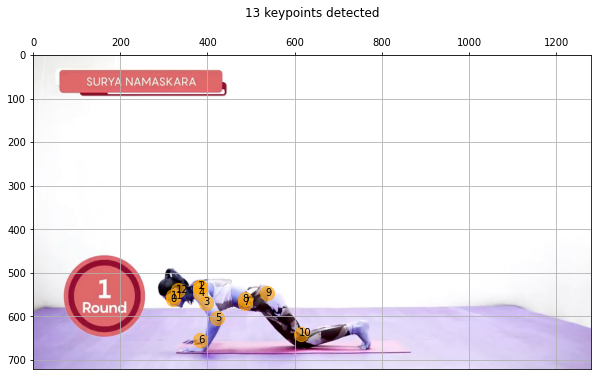

In [173]:
test_keypts_array = show_keypoints(global_image, global_humans, color='orange', show_BG = 'original')

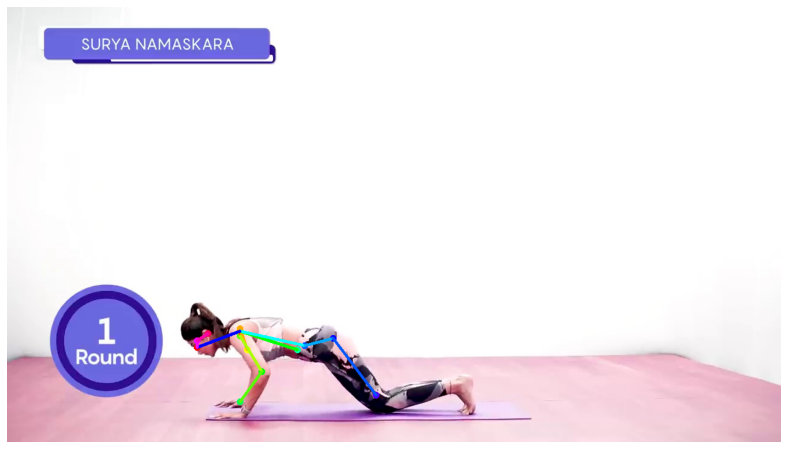

In [176]:
test_image, test_humans = show_pose(global_image_path, estimator=global_e, show_BG=True)

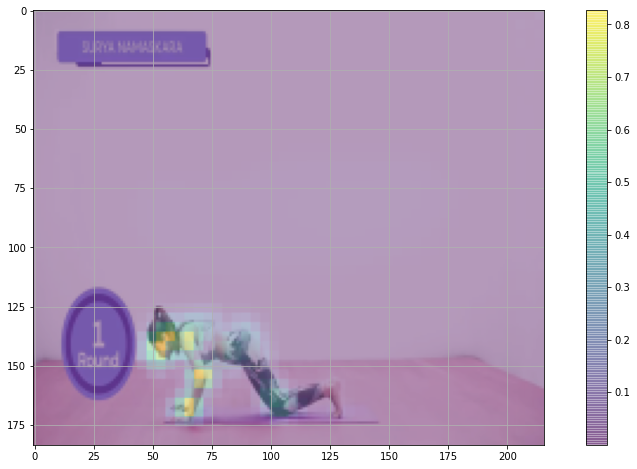

In [177]:
show_heatmap(image=global_image, estimator = global_e, show_BG = True)

In [178]:
test_keypts_array[0]

array([320, 561])

In [179]:
type(common.read_imgfile(global_image_path))

numpy.ndarray

## Pose Identification [NOT REQUIRED]

This will involve making a classification model to predict which pose is in the current image/frame.   
Initially we will be using a smaller dataset from: [Yoga Pose Dataset](https://www.kaggle.com/niharika41298/yoga-poses-dataset)  
*  This dataset has 5 classes
*  The dataset is provided as two directories: `Train` and `Test`. Which have subdirectories for each of the 5 classes.  
  
Then we will use a much larger dataset from:[Yoga Pose Image Classification Dataset](https://www.kaggle.com/shrutisaxena/yoga-pose-image-classification-dataset/tasks?taskId=3946)  

### Inferences with all the time spent till now:   
1.  You cannot use the images imported using ImageDataGenerator in order to get the **pose keypoints** using `estimator.inference()`.[Gives empty results most of the times]  
2.  There is no need to convert images to pose keypoint sbefore feeding to the model to predict the pose. Instead the model can be directly trained on the raw images.  
3.  The last and the most important one: `There is no need to make a model to predict a pose` because:    
  
    a.  We are trying to use videos for supervision and hence a full asan has many poses and we are trying to supervise them all and as such it is enough for us to know what asan is being performed rather than a particular pose.  **[No need for prediction]**  
    b.  We can **make the user select what asan** he/ she will be performing. This is more efficient.  





In [ ]:
dataset_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/5_class_yoga_poses_dataset/'
train_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/5_class_yoga_poses_dataset/TRAIN/'
test_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/5_class_yoga_poses_dataset/TEST/'
sample_image_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/5_class_yoga_poses_dataset/TRAIN/plank/00000176.jpg'

In [ ]:
dim_1 = []
dim_2 = []
channels = []
for image_name in os.listdir(train_path+'plank/'):
  x,y, channel = plt.imread(train_path+'plank/'+image_name).shape
  dim_1.append(x)
  dim_2.append(y)
  channels.append(channel)

In [ ]:
np.mean(dim_1), np.mean(dim_2)

(652.4699248120301, 953.0526315789474)

In [ ]:
np.median(dim_1), np.median(dim_2)

(579.5, 763.5)

In [ ]:
np.min(dim_1), np.max(dim_1)

(75, 2612)

In [ ]:
np.min(dim_2), np.max(dim_2)

(75, 4854)

In [ ]:
np.min(channels), np.max(channels)

(3, 4)

In [ ]:
IMG_HEIGHT = 640
IMG_WIDTH = 800

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    # rescale=1/255,
                                   horizontal_flip = True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')
validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_path,  # This is the source directory for training images
        target_size=(IMG_HEIGHT, IMG_WIDTH),  # All images will be resized to 300x300
        batch_size=32,
        class_mode='categorical',
        color_mode = 'rgb')

# Flow testing images in batches of 32 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        test_path,  # This is the source directory for training images
        target_size=(IMG_HEIGHT, IMG_WIDTH),  # All images will be resized to 300x300
        batch_size=32,
        class_mode='categorical',
        color_mode = 'rgb')

Found 1081 images belonging to 5 classes.
Found 470 images belonging to 5 classes.


Now that we have loaded all the images, we need to get pose joint coordinates for each image

In [ ]:
train_generator

In [ ]:
x, y = train_generator[0]

In [ ]:
x.shape, y.shape

((32, 640, 800, 3), (32, 5))

In [ ]:
# Create a function that takes in image as input and returns its keypoints
def get_img_keypoints(image, estimator = e):
    human_joints = e.inference(image,
                          resize_to_default=(w > 0 and h > 0),
                          upsample_size=4.0)
    # print(human_joints)
    key_pts = get_keypoints(image, human_joints)
    return key_pts


In [ ]:
x[0].shape

(640, 800, 3)

In [ ]:
image_global.shape

(380, 380, 3)

In [ ]:
# get_img_keypoints(x[0])
e.inference(x[12],resize_to_default=(w > 0 and h > 0), upsample_size=4.0)

[BodyPart:0-(0.50, 0.63) score=0.25 BodyPart:1-(0.56, 0.72) score=0.58 BodyPart:2-(0.60, 0.69) score=0.40 BodyPart:5-(0.50, 0.73) score=0.45 BodyPart:8-(0.59, 0.90) score=0.39 BodyPart:11-(0.53, 0.90) score=0.32 BodyPart:15-(0.51, 0.61) score=0.28 BodyPart:16-(0.59, 0.64) score=0.19 BodyPart:17-(0.54, 0.62) score=0.32]

In [ ]:
e.heatMat[0][0]

0.9949278

In [ ]:
# body_part_index = 1
# for wi in range(int(432/2)):
#   for hi in range(int(368/2)):
#     if(np.argmax(e.heatMat[hi][wi]) == 18):
#       print(f"height:{hi}, width:{wi}")
#       print(e.heatMat[hi][wi])
#       break

In [ ]:
type(x[0])

numpy.ndarray

In [ ]:
y[0]

array([1., 0., 0., 0., 0.], dtype=float32)

In [ ]:
1081/32

In [ ]:
for x,y in train_generator:
  print(x.shape, y.shape)
  break

In [ ]:
train_generator.class_indices

In [ ]:
def unbatchify(batch_data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # joints = []
  for image, label in batch_data.unbatch().as_numpy_iterator():
    images.append(image)
    # joints.append(get_img_keypoints(image))
    labels.append(label)
  return images, labels

In [ ]:
# unbatched_images, unbatched_labels = unbatchify(train_generator)

In [ ]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:

dataset_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/5_class_yoga_poses_dataset/'
train_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/5_class_yoga_poses_dataset/TRAIN/'
test_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/5_class_yoga_poses_dataset/TEST/'
# sample_image_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/5_class_yoga_poses_dataset/TRAIN/plank/00000176.jpg'

In [ ]:
df = pd.DataFrame(columns = ['file_name', 'yoga_pose'])

In [ ]:
i = 0
j = 0
for x in os.listdir(train_path):
  path = train_path + x + "/"
  for image_name in os.listdir(path):
    df.loc[i,'file_name'] = path+image_name
    df.loc[i, 'yoga_pose'] = x
    i+=1
  print(f"Number of image paths extracted from {x} are {i-j}")
  j = i

In [ ]:
len(df)

1081

In [ ]:
# df[:10]

In [ ]:
# CAUTION : THE BELOW LINE HAS BEEN COMMENTED OUT TO PREVENT UNWANTED OVERWRITING OF LABELS FILE
df.to_csv('/content/drive/MyDrive/Datasets/yoga_supervisor/5_class_yoga_poses_dataset.csv', index = False)

In [ ]:
labels_df = pd.read_csv("/content/drive/MyDrive/Datasets/yoga_supervisor/5_class_yoga_poses_dataset.csv")

In [ ]:
labels_df.iloc[440][0]

'/content/drive/MyDrive/Datasets/yoga_supervisor/5_class_yoga_poses_dataset/TRAIN/plank/00000181.jpg'

In [ ]:
filepaths = labels_df['file_name']
labels = labels_df['yoga_pose']

In [ ]:
len(filepaths), len(labels)

(1081, 1081)

In [ ]:
NUM_CLASSES = len(np.unique(labels))

In [ ]:
NUM_CLASSES

5

In [ ]:
UNIQUE_LABELS = np.unique(labels)

In [ ]:
UNIQUE_LABELS

array(['downdog', 'goddess', 'plank', 'tree', 'warrior2'], dtype=object)

In [ ]:
# To convert into one hot labels
(labels[0] == UNIQUE_LABELS).astype(int)

array([1, 0, 0, 0, 0])

In [ ]:
# Function to one hot encode labels
def one_hot_encoder(labels, unique_labels = UNIQUE_LABELS):
  one_hot_labels = []
  for label in labels:
    one_hot =(label == UNIQUE_LABELS).astype(int)
    one_hot_labels.append(one_hot)
  return one_hot_labels

In [ ]:
one_hot_labels = one_hot_encoder(labels)
one_hot_labels[:5]

In [ ]:
X = filepaths.copy()

In [ ]:
y = one_hot_labels.copy()

In [ ]:
len(X), len(y)

(1081, 1081)

## Step 3: Similarity Calculation

In [185]:
# vid_path = "/content/drive/MyDrive/Datasets/yoga_supervisor/yoga_videos/yoga_1.mp4"
image_path = '/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/yoga_2_1/'

In [202]:
# !pip install dtaidistance
from dtaidistance import dtw

In [189]:
test_all_keypoints = get_all_keypoints(image_path, global_e)

In [190]:
len(test_all_keypoints)

271

In [198]:
# Calculate similarity between two poses
test_similarity = [1-dtw.distance(test_all_keypoints[4][i]/np.linalg.norm(test_all_keypoints[4][i]), test_all_keypoints[54][i]/np.linalg.norm(test_all_keypoints[54][i])) for i in range(min(len(test_all_keypoints[4]),len(test_all_keypoints[54])))]
print(test_similarity)

[0.24308518647511046, 0.259228651428684, 0.2024733376947465, 0.47090027506207255, 0.31407882724034575, 0.4544229930494422, 0.4062673124033698, 0.524394629010948, 0.7086792787819989]


In [199]:
test_average_similarity = np.mean(test_similarity)
print(test_average_similarity)

0.39817005457185756


In [200]:
if test_average_similarity >0.5:
  print('both pictures have similar pose')
else:
  print('both pictures have different poses')

both pictures have different poses


In [201]:
# Similarity function
import dtaidistance as dtw
def get_similarity(image_points, reference_points):
  """
  Calculate similarity between two poses ( keypoints' arrays passed )
  Returns similarity percentage.
  """
  similarity = [1-dtw.distance(image_points[i]/np.linalg.norm(image_points[i]),  # Normalized image points 
                              reference_points[i]/np.linalg.norm(reference_points[i]))  # Normalized reference points
                for i in range(min(len(image_points),len(reference_points)))]  # because no. of keypoints identified for reference and given images can be different
  average_similarity = np.mean(similarity)
  return np.round(average_similarity*100,2)

In [ ]:
path_1 = '/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/yoga_2_1/'
path_2 = '/content/drive/MyDrive/Datasets/yoga_supervisor/extracted_images/yoga_2_2/'
all_key_points_1 = get_all_keypoints(path_1, global_e)
all_key_points_2 = get_all_keypoints(path_2, global_e)
similarities = []
for i in range(min(len(all_key_points_1),len(all_key_points_2))):
  similarity = get_similarity(all_key_points_1[i], all_key_points_2[i])
  similarities.append(similarity)
  
print(len(similarities))


261


In [ ]:
print(similarities)

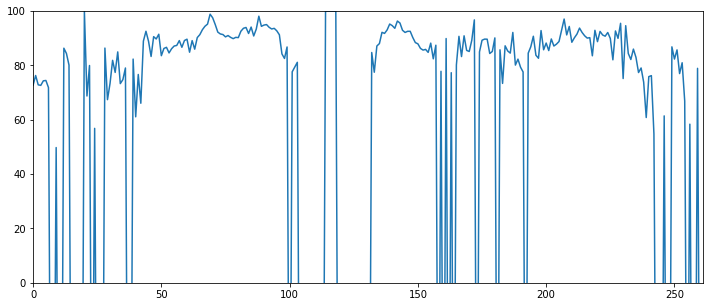

In [ ]:
plt.figure(figsize=(12,5))
plt.axis([0, len(similarities), 0, 100])
plt.plot(range(0, len(similarities)), similarities)

## Challenges
There are still many challenges with this approach.

1) Similarity comparison means you are comparing exact pose at the exact time which doesn't work as people might take slightly different time to complete the same task and this doesn't mean that they are doing it wrong. So, need a different method to compare correctness or something that doesn't give the duration of a pose too much value.

2) I did pose estimation using tf_pose library which gives good results but misses out many times. This also leads to untrue dissimilarities. Hence, I need a method to ignore these or a better algorithm for pose estimation. Posenet would work but it doesn't have a tf2 implementation.

3) This method of comparison depends a lot on camera angles. Hence, I want to reduce that dependency too.  

4) Similarity comparison takes a lot of time. This is another obstacle for real-time usage. 
